### Planning

Goal: Why are our customers churning?

*Specific questions to address*
- Does the month they signed up influence churn? 
    - plot the rate of churn on a line chart, where x is tenure and y is the customers churned/total customers
- Which, if any, features indicate a higher liklihood of churn?
- Is there a price threshold for likelihood of churn, specific to services? What is that point?
- What is the churn rate in the 13th month for one-year customers compared to month-to-month customers?

data_dictionary - variables included and why or not why? (doesn't have to be an actual python dictionary)

## Acquire

In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns

from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.metrics import confusion_matrix, classification_report
from graphviz import Source

import acquire
import prep
import split_scale

import warnings 
warnings.filterwarnings("ignore")

In [2]:
query = """
    SELECT * 
    FROM customers
    JOIN internet_service_types USING (internet_service_type_id)
    JOIN contract_types USING (contract_type_id)
    JOIN payment_types USING (payment_type_id)
    """
db = "telco_churn"

In [138]:
df = acquire.get_data(query, db)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7043 non-null int64
contract_type_id            7043 non-null int64
internet_service_type_id    7043 non-null int64
customer_id                 7043 non-null object
gender                      7043 non-null object
senior_citizen              7043 non-null int64
partner                     7043 non-null object
dependents                  7043 non-null object
tenure                      7043 non-null int64
phone_service               7043 non-null object
multiple_lines              7043 non-null object
online_security             7043 non-null object
online_backup               7043 non-null object
device_protection           7043 non-null object
tech_support                7043 non-null object
streaming_tv                7043 non-null object
streaming_movies            7043 non-null object
paperless_billing           7043 non-null object
monthly_charges 

In [51]:
df.describe()

,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges
count,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000,7043.000000
mean,2.315633,1.690473,1.872923,0.162147,32.371149,64.761692
std,1.148907,0.833755,0.737796,0.368612,24.559481,30.090047
min,1.000000,1.000000,1.000000,0.000000,0.000000,18.250000
25%,1.000000,1.000000,1.000000,0.000000,9.000000,35.500000
50%,2.000000,1.000000,2.000000,0.000000,29.000000,70.350000
75%,3.000000,2.000000,2.000000,0.000000,55.000000,89.850000
max,4.000000,3.000000,3.000000,1.000000,72.000000,118.750000


In [52]:
# no nulls were found!
df.isnull().sum()

payment_type_id             0
contract_type_id            0
internet_service_type_id    0
customer_id                 0
gender                      0
senior_citizen              0
partner                     0
dependents                  0
tenure                      0
phone_service               0
multiple_lines              0
online_security             0
online_backup               0
device_protection           0
tech_support                0
streaming_tv                0
streaming_movies            0
paperless_billing           0
monthly_charges             0
total_charges               0
churn                       0
internet_service_type       0
contract_type               0
payment_type                0
dtype: int64

In [53]:
df.head()

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.4,No,DSL,Month-to-month,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,DSL,Month-to-month,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,DSL,Month-to-month,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.1,Yes,DSL,Month-to-month,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.5,Yes,DSL,Month-to-month,Bank transfer (automatic)


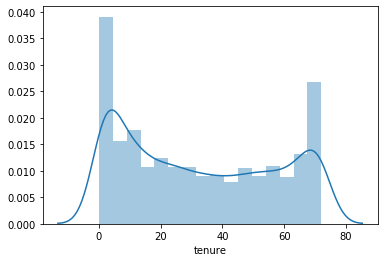

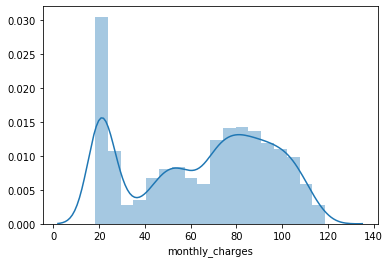

In [54]:
sns.distplot(df.tenure)
plt.show()
sns.distplot(df.monthly_charges)
plt.show()

In [55]:
df.churn.value_counts()

No     5174
Yes    1869
Name: churn, dtype: int64

In [56]:
print("The average rate of churn is {:.2f}".format(1869/(1869+5163)))

The average rate of churn is 0.27


### Prepare - Baseline

In [139]:
# cleaned total_charges column
df = prep.clean_data(df)

In [58]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7032 non-null int64
contract_type_id            7032 non-null int64
internet_service_type_id    7032 non-null int64
customer_id                 7032 non-null object
gender                      7032 non-null object
senior_citizen              7032 non-null int64
partner                     7032 non-null object
dependents                  7032 non-null object
tenure                      7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
online_security             7032 non-null object
online_backup               7032 non-null object
device_protection           7032 non-null object
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
paperless_billing           7032 non-null object
monthly_charges 

In [159]:
# split data using a train of 80% and a default random state of 123
train, test = split_scale.split_my_data(df, .80)

In [141]:
# split features and target
X_train = train.drop(columns="churn")
X_test = train.drop(columns="churn")
y_train = train[["churn"]]
y_test = test[["churn"]]

In [15]:
# change churn values from no/yes to 0/1
y_train, y_test = prep.encode(y_train, y_test, "churn")
y_train.info()
y_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 1 columns):
churn    5625 non-null int64
dtypes: int64(1)
memory usage: 87.9 KB


,churn
5474,0
5426,0
3563,0
2096,0
7019,0


In [17]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 23 columns):
payment_type_id             5625 non-null int64
contract_type_id            5625 non-null int64
internet_service_type_id    5625 non-null int64
customer_id                 5625 non-null object
gender                      5625 non-null object
senior_citizen              5625 non-null int64
partner                     5625 non-null object
dependents                  5625 non-null object
tenure                      5625 non-null int64
phone_service               5625 non-null object
multiple_lines              5625 non-null object
online_security             5625 non-null object
online_backup               5625 non-null object
device_protection           5625 non-null object
tech_support                5625 non-null object
streaming_tv                5625 non-null object
streaming_movies            5625 non-null object
paperless_billing           5625 non-null object
monthly_charg

,payment_type_id,contract_type_id,internet_service_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,internet_service_type,contract_type,payment_type
5474,4,3,1,2226-ICFDO,Female,0,Yes,Yes,72,Yes,...,Yes,Yes,Yes,Yes,Yes,85.90,6110.75,DSL,Two year,Credit card (automatic)
5426,2,3,1,1221-GHZEP,Female,0,No,No,62,Yes,...,No,Yes,No,Yes,Yes,65.10,3846.75,DSL,Two year,Mailed check
3563,1,1,3,3807-XHCJH,Female,0,Yes,Yes,1,Yes,...,No internet service,No internet service,No internet service,No internet service,No,20.00,20.00,None,Month-to-month,Electronic check
2096,3,1,2,4067-HLYQI,Female,0,No,No,33,Yes,...,No,No,No,No,Yes,70.40,2406.10,Fiber optic,Month-to-month,Bank transfer (automatic)
7019,2,3,3,9593-CVZKR,Female,0,Yes,Yes,56,Yes,...,No internet service,No internet service,No internet service,No internet service,Yes,24.45,1385.85,None,Two year,Mailed check


In [18]:
# drop all columns that aren't numeric
X_train.drop(columns=["customer_id","gender","partner","dependents","phone_service"], inplace=True)
X_train.drop(columns=["multiple_lines","online_security","online_backup","device_protection","tech_support"], inplace=True)
X_train.drop(columns=["streaming_tv","streaming_movies","paperless_billing"], inplace=True)
X_train.drop(columns=["internet_service_type","contract_type","payment_type"], inplace=True)

In [19]:
X_train.info()
X_train.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 7 columns):
payment_type_id             5625 non-null int64
contract_type_id            5625 non-null int64
internet_service_type_id    5625 non-null int64
senior_citizen              5625 non-null int64
tenure                      5625 non-null int64
monthly_charges             5625 non-null float64
total_charges               5625 non-null float64
dtypes: float64(2), int64(5)
memory usage: 351.6 KB


,payment_type_id,contract_type_id,internet_service_type_id,senior_citizen,tenure,monthly_charges,total_charges
5474,4,3,1,0,72,85.90,6110.75
5426,2,3,1,0,62,65.10,3846.75
3563,1,1,3,0,1,20.00,20.00
2096,3,1,2,0,33,70.40,2406.10
7019,2,3,3,0,56,24.45,1385.85


### Model - Baseline

In [21]:
# building model with a decision tree and using a random state of 123
clf = DecisionTreeClassifier(max_depth=5, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [22]:
y_pred = clf.predict(X_train)
y_pred

array([0, 0, 0, ..., 1, 0, 0])

In [23]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.99080695, 0.00919305],
       [0.99080695, 0.00919305],
       [0.60902256, 0.39097744],
       ...,
       [0.26755853, 0.73244147],
       [0.60902256, 0.39097744],
       [0.90598291, 0.09401709]])

In [25]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.80


In [26]:
confusion_matrix(y_train, y_pred)

array([[3856,  294],
       [ 837,  638]])

In [27]:
sorted(y_train.churn.unique())

[0, 1]

In [28]:
y_train.churn.value_counts()

0    4150
1    1475
Name: churn, dtype: int64

In [29]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87      4150
           1       0.68      0.43      0.53      1475

    accuracy                           0.80      5625
   macro avg       0.75      0.68      0.70      5625
weighted avg       0.79      0.80      0.78      5625



In [30]:
dot_data = export_graphviz(clf, out_file=None) 
graph = Source(dot_data) 

graph.render('telco_decision_tree', view=True)

'telco_decision_tree.pdf'

### Explore - MVP 

Q1: Could the month in which they signed up influence churn? i.e. if a cohort is identified by tenure, is there a cohort or cohorts who have a higher rate of churn than other cohorts? (Plot the rate of churn on a line chart where x is the tenure and y is the rate of churn (customers churned/total customers)

In [160]:
# encode churn value for plotting
train1, test1 = prep.encode(train, test, "churn")

In [161]:
train1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)
test1.drop(columns=["payment_type_id","contract_type_id","internet_service_type_id"], inplace=True)

In [162]:
train1.info()
train1.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5625 entries, 5474 to 3582
Data columns (total 21 columns):
customer_id              5625 non-null object
gender                   5625 non-null object
senior_citizen           5625 non-null int64
partner                  5625 non-null object
dependents               5625 non-null object
tenure                   5625 non-null int64
phone_service            5625 non-null object
multiple_lines           5625 non-null object
online_security          5625 non-null object
online_backup            5625 non-null object
device_protection        5625 non-null object
tech_support             5625 non-null object
streaming_tv             5625 non-null object
streaming_movies         5625 non-null object
paperless_billing        5625 non-null object
monthly_charges          5625 non-null float64
total_charges            5625 non-null float64
churn                    5625 non-null int64
internet_service_type    5625 non-null object
contract_type    

,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type
5474,2226-ICFDO,Female,0,Yes,Yes,72,Yes,Yes,Yes,No,...,Yes,Yes,Yes,Yes,85.90,6110.75,0,DSL,Two year,Credit card (automatic)
5426,1221-GHZEP,Female,0,No,No,62,Yes,No,Yes,No,...,Yes,No,Yes,Yes,65.10,3846.75,0,DSL,Two year,Mailed check
3563,3807-XHCJH,Female,0,Yes,Yes,1,Yes,No,No internet service,No internet service,...,No internet service,No internet service,No internet service,No,20.00,20.00,0,None,Month-to-month,Electronic check
2096,4067-HLYQI,Female,0,No,No,33,Yes,No,No,No,...,No,No,No,Yes,70.40,2406.10,0,Fiber optic,Month-to-month,Bank transfer (automatic)
7019,9593-CVZKR,Female,0,Yes,Yes,56,Yes,Yes,No internet service,No internet service,...,No internet service,No internet service,No internet service,Yes,24.45,1385.85,0,None,Two year,Mailed check


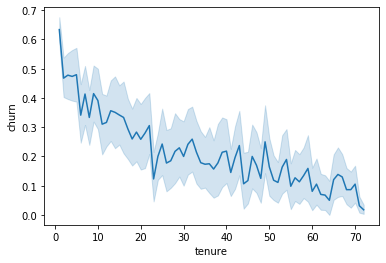

In [500]:
sns.lineplot(x="tenure", y="churn", data=train1)
plt.show()
# sns.distplot(train1[["tenure","churn"]].tenure)
# plt.show()

> The highest churn rates happen in the beginning, specifically in the first month

Q2: Are there features that indicate a higher propensity to churn? like type of internet service, type of phone service, online security and backup, senior citizens, paying more than x% of customers with the same services, etc.?

##### Explore internet services

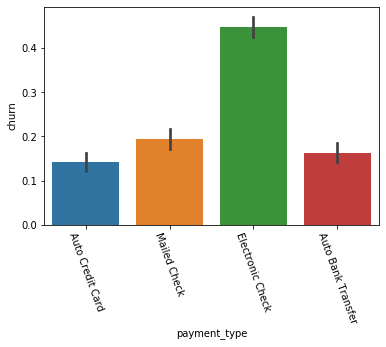

In [229]:
# plot internet services
fig = sns.barplot(x="payment_type", y="churn", data=train1)
fig.set_xticklabels(["Auto Credit Card", "Mailed Check","Electronic Check", "Auto Bank Transfer"])
plt.xticks(rotation=-70)
plt.show()

> Non-automatic payment types (mailed check and electronic check) have higher churn rates

##### Explore phone services

In [164]:
# multiple lines is redundant information of phone service, therefore, drop phone service column
print(train1.multiple_lines.value_counts())
print()
print(train1.phone_service.value_counts())

No                  2736
Yes                 2339
No phone service     550
Name: multiple_lines, dtype: int64

Yes    5075
No      550
Name: phone_service, dtype: int64


In [165]:
train1.drop(columns = "phone_service", inplace=True)
test1.drop(columns = "phone_service", inplace=True)

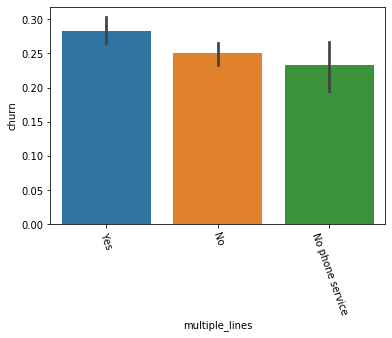

In [145]:
# plot phone type
sns.barplot(x="multiple_lines", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> The phone service type does not appear to affect churn

##### Explore online services

H0: online security is indepedent of online backup

In [191]:
observed = pd.crosstab(train1.online_security,train1.online_backup)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
online_backup          No  No internet service   Yes
online_security                                     
No                   1756                    0  1033
No internet service     0                 1232     0
Yes                   710                    0   894

Expected
[[1222.6976      610.85297778  955.44942222]
 [ 540.1088      269.83537778  422.05582222]
 [ 703.1936      351.31164444  549.49475556]]

chi^2 = 5810.1221
p     = 0.0000


The p-value is zero, therefore, we reject the null hypothesis

In [192]:
print(train1.online_security.value_counts())
print()
print(train.online_backup.value_counts())

No                     2789
Yes                    1604
No internet service    1232
Name: online_security, dtype: int64

No                     2466
Yes                    1927
No internet service    1232
Name: online_backup, dtype: int64


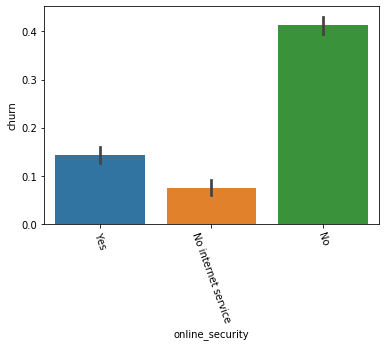

In [193]:
# plot online security
sns.barplot(x="online_security", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> People with no online security are more likely to stay. Does the online security have an unreasonable price?

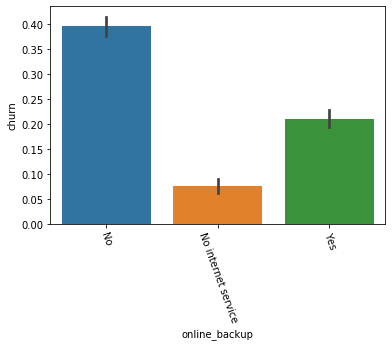

In [169]:
# plot online backup
sns.barplot(x="online_backup", y="churn", data=train1)
plt.xticks(rotation=-70)
plt.show()

> People without online backup are more likely to churn. Is our online backup too expensive and folks look for it elsewhere? Or does having this feature make them feel more secure and they are more likely to stay?

In [290]:
# make a new column combining online security and backup
conditions = [
    (train1.online_security == "No") & (train1.online_backup == "No"),
    (train1.online_security == "Yes") & (train1.online_backup == "No"),
    (train1.online_security == "No") & (train1.online_backup == "Yes"),
    (train1.online_security == "Yes") & (train1.online_backup == "Yes")]
    
choices = ['No additions', 'Only security', 'Only backup', 'Both']
train1['online_additions'] = np.select(conditions, choices, default='No internet')

In [292]:
# drop old online columns
train1.drop(columns=["online_security","online_backup"],inplace=True)

In [294]:
train1.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type,online_additions
5474,2226-ICFDO,Female,0,Yes,Yes,72,Yes,Yes,Yes,Yes,Yes,Yes,85.90,6110.75,0,DSL,Two year,Credit card (automatic),Only security
5426,1221-GHZEP,Female,0,No,No,62,No,No,Yes,No,Yes,Yes,65.10,3846.75,0,DSL,Two year,Mailed check,Only security
3563,3807-XHCJH,Female,0,Yes,Yes,1,No,No internet service,No internet service,No internet service,No internet service,No,20.00,20.00,0,None,Month-to-month,Electronic check,No internet
2096,4067-HLYQI,Female,0,No,No,33,No,No,No,No,No,Yes,70.40,2406.10,0,Fiber optic,Month-to-month,Bank transfer (automatic),No additions
7019,9593-CVZKR,Female,0,Yes,Yes,56,Yes,No internet service,No internet service,No internet service,No internet service,Yes,24.45,1385.85,0,None,Two year,Mailed check,No internet


In [286]:
train1.online_additions.value_counts()

No additions     1756
No internet      1232
Only backup      1033
Both              894
Only security     710
Name: online_additions, dtype: int64

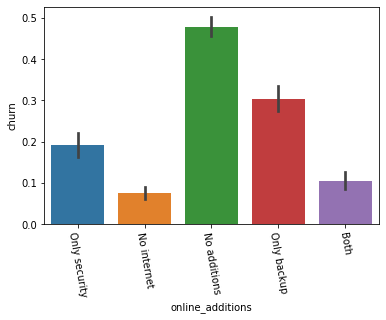

In [299]:
# plot all services 
sns.barplot(x="online_additions", y="churn", data=train1)
plt.xticks(rotation=-80)
plt.show()

> People with no online additions are more likely to churn 

##### Explore senior citizens

In [199]:
train1.senior_citizen.value_counts()

0    4729
1     896
Name: senior_citizen, dtype: int64

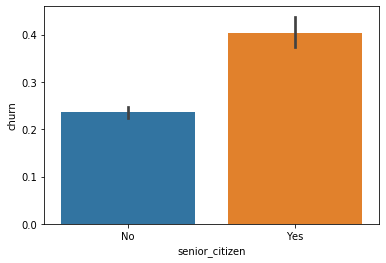

In [230]:
fig = sns.barplot(x="senior_citizen", y="churn", data=train1)
fig.set_xticklabels(["No","Yes"])
plt.show()

> Senior citizens have a higher churn rate than non-senior citizens. Are they paying higher rates?

##### Explore streaming services

H0: Streaming movies is indepedent of streaming tv

In [309]:
observed = pd.crosstab(train1.streaming_movies,train1.streaming_tv)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[1615    0  610]
 [   0 1232    0]
 [ 628    0 1540]]

Expected
[[887.23111111 487.32444444 850.44444444]
 [491.26684444 269.83537778 470.89777778]
 [864.50204444 474.84017778 828.65777778]]

chi^2 = 6695.4471
p     = 0.0000


The p-value is zero, therefore, we reject the null hypothesis

In [303]:
print(train1.streaming_movies.value_counts())
print()
print(train1.streaming_tv.value_counts())

No                     2225
Yes                    2168
No internet service    1232
Name: streaming_movies, dtype: int64

No                     2243
Yes                    2150
No internet service    1232
Name: streaming_tv, dtype: int64


In [311]:
# make a new column combining streaming services
conditions = [
    (train1.streaming_movies == "No") & (train1.streaming_tv == "No"),
    (train1.streaming_movies == "No") & (train1.streaming_tv == "Yes"),
    (train1.streaming_movies == "Yes") & (train1.streaming_tv == "No"),
    (train1.streaming_movies == "Yes") & (train1.streaming_tv == "Yes")]
    
choices = ['No streaming', 'One stream', 'One stream', 'Two streams']
train1['streaming'] = np.select(conditions, choices, default='No internet')

In [313]:
train1.streaming.value_counts()

No streaming    1615
Two streams     1540
One stream      1238
No internet     1232
Name: streaming, dtype: int64

In [315]:
# drop old streaming columns
train1.drop(columns=["streaming_movies","streaming_tv"], inplace=True)

In [316]:
train1.head()

,customer_id,gender,senior_citizen,partner,dependents,tenure,multiple_lines,device_protection,tech_support,paperless_billing,monthly_charges,total_charges,churn,internet_service_type,contract_type,payment_type,online_additions,streaming
5474,2226-ICFDO,Female,0,Yes,Yes,72,Yes,Yes,Yes,Yes,85.90,6110.75,0,DSL,Two year,Credit card (automatic),Only security,Two streams
5426,1221-GHZEP,Female,0,No,No,62,No,No,Yes,Yes,65.10,3846.75,0,DSL,Two year,Mailed check,Only security,One stream
3563,3807-XHCJH,Female,0,Yes,Yes,1,No,No internet service,No internet service,No,20.00,20.00,0,None,Month-to-month,Electronic check,No internet,No internet
2096,4067-HLYQI,Female,0,No,No,33,No,No,No,Yes,70.40,2406.10,0,Fiber optic,Month-to-month,Bank transfer (automatic),No additions,No streaming
7019,9593-CVZKR,Female,0,Yes,Yes,56,Yes,No internet service,No internet service,Yes,24.45,1385.85,0,None,Two year,Mailed check,No internet,No internet


##### Explore - paying more than x% of customers with the same services

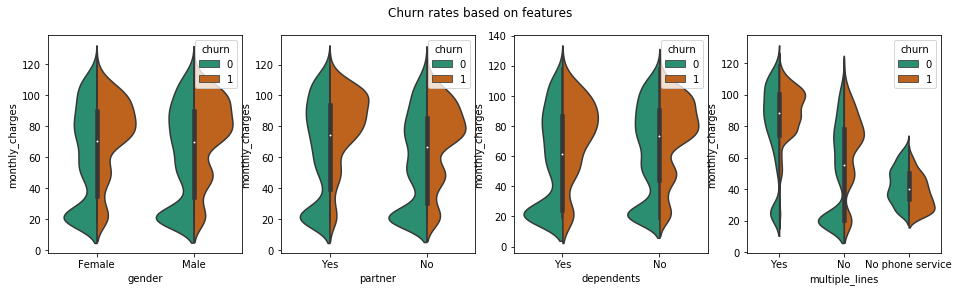

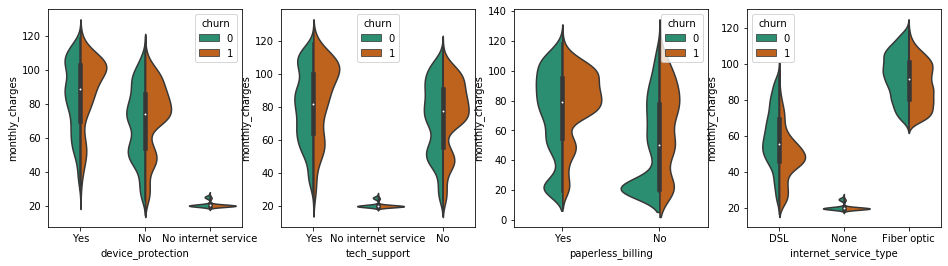

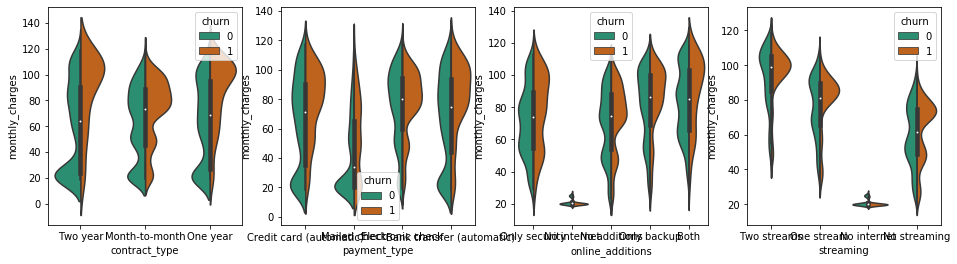

In [467]:
# plotting all the objects on a violin plot
features = ['gender', 'partner', 'dependents', 'multiple_lines',]
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2")

plt.suptitle('Churn rates based on features')

features = ['device_protection', 'tech_support', 'paperless_billing', 'internet_service_type']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2")
    
features = ['contract_type', 'payment_type', 'online_additions', 'streaming']
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
for i, feature in enumerate(features):
    sns.violinplot(feature, 'monthly_charges', hue='churn', data=train1, split=True, ax=ax[i], palette="Dark2")

plt.show()

> um

Q3. Is there a price threshold for specific services where the likelihood of churn increases once price for those services goes past that point? If so, what is that point for what service(s)?

- how the heck do I figure that out?

Q4. If we looked at churn rate for month-to-month customers after the 12th month and that of 1-year contract customers after the 12th month, are those rates comparable?

In [505]:
print('The churn rate after 12 months for a month-to-month contract:')
print(f'{train [(train1.tenure > 12) & (train1.contract_type == "Month-to-month")].churn.mean():.2}')
print('The churn rate after 12 months for a one-year contract:')
print(f'{train [(train1.tenure > 12) & (train1.contract_type == "One year")].churn.mean():.2}')

The churn rate after 12 months for a month-to-month contract:
0.33
The churn rate after 12 months for a one-year contract:
0.11


The churn rate for month-to-month is still much higher than a one-year contract. Therefore, we must convert people to longer contracts. 

Q5. Controlling for services (phone_id, internet_service_type_id, online_security_backup, device_protection, tech_support, and contract_type_id), is the mean monthly_charges of those who have churned significantly different from that of those who have not churned? (Use a t-test to answer this.)

Q6. How much of monthly_charges can be explained by internet_service_type? (hint: correlation test). State your hypotheses and your conclusion clearly.

H0: monthly_charges are independent of internet_service_type

In [519]:
observed = pd.crosstab(train1.monthly_charges,train1.internet_service_type)
chi2, p, degf, expected = stats.chi2_contingency(observed)

print('Observed')
print(observed.values)
print('\nExpected')
print(expected)
print('')
print(f'chi^2 = {chi2:.4f}')
print(f'p     = {p:.4f}')

Observed
[[0 0 1]
 [0 0 1]
 [0 0 2]
 ...
 [0 2 0]
 [0 1 0]
 [0 1 0]]

Expected
[[0.34275556 0.43822222 0.21902222]
 [0.34275556 0.43822222 0.21902222]
 [0.68551111 0.87644444 0.43804444]
 ...
 [0.68551111 0.87644444 0.43804444]
 [0.34275556 0.43822222 0.21902222]
 [0.34275556 0.43822222 0.21902222]]

chi^2 = 9502.6892
p     = 0.0000


> The p-value is zero, therefore, we reject the null hypothesis

Q7. How much of monthly_charges can be explained by internet_service_type + phone service type (0, 1, or multiple lines). State your hypotheses and your conclusion clearly.

In [512]:
print(train1.multiple_lines.value_counts())
print()
print(train1.internet_service_type.value_counts())

No                  2736
Yes                 2339
No phone service     550
Name: multiple_lines, dtype: int64

Fiber optic    2465
DSL            1928
None           1232
Name: internet_service_type, dtype: int64


Q8. Create visualizations exploring the interactions of variables (independent with independent and independent with dependent). The goal is to identify features that are related to churn, identify any data integrity issues, understand 'how the data works'. For example, we may find that all who have online services also have device protection. In that case, we don't need both of those. (The visualizations done in your analysis for questions 1-5 count towards the requirements below)

Q9. What can you say about each variable's relationship to churn, based on your initial exploration? If there appears to be some sort of interaction or correlation, assume there is no causal relationship and brainstorm (and document) ideas on reasons there could be correlation

Q10. Summarize your conclusions, provide clear answers to the specific questions, and summarize any takeaways/action plan from the work above.